# Autopilot with Keras & TensorFlow
---

`Reference:`
Will Roscoe - Lane Following Autopilot with Keras & Tensorflow
https://wroscoe.github.io/keras-lane-following-autopilot.html


In [23]:
import os
import urllib.request
import pickle
import matplotlib
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from keras import callbacks
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation
from keras.layers import Dropout, Flatten, Dense

%matplotlib inline

In [27]:
import tensorflow as tf
from keras import backend as K

sess = tf.Session()
K.set_session(sess)

### Load driving data from AWS

>The dataset is composed of ~7900 images and steering angles collected as I manually drove the car. About 2/3 of the images are with the car between the lines. The other third is of the car starting off course and correcting by driving back to between the lines.

In [4]:
# driving data size: (450Mb) 
driv_data = 'https://s3.amazonaws.com/donkey_resources/indoor_lanes.pkl'
fpath, headers = urllib.request.urlretrieve(driv_data)
print(fpath)

/var/folders/zx/374_2_w5399c51yc1f4mt7cc0000gn/T/tmp41i77yix


>The dataset consists of 2 pickled arrays. $X$ are the image arrays and $Y$ is an array of the coresponding steering angles.

X.shape:  (7892, 120, 160, 3)
Y.shape:  (7892,)


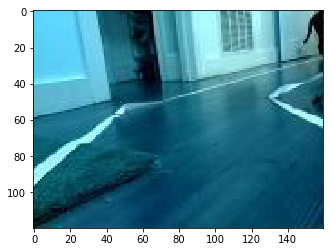

In [17]:
with open(fpath, 'rb') as f:
    X, Y = pickle.load(f)
    
print('X.shape: ', X.shape)
print('Y.shape: ', Y.shape)
imshow(X[0]);

In [12]:
print(Y[:50])

[ 1  1  1  1  1  1  1  1  4  0  2  3  3  4  6  7  8  8 10 12 15 20 21 21 22
 22 18 16 14 11  9  8  8  7  7  4  3 -3 -3 -3  0 12 13 19 23  6 20 21 23 25]


### Split Data

>Here we'll shuffle our data and separate the data into three parts.

>* Training data will be used to train our driving model, 

>* Validation data is used avoid overfitting the model and 

>* Test data is used to test if our model learned anything.

In [16]:
#shuffle both X and Y the same way
def unison_shuffled_cp(X, Y):
    assert len(X) == len(Y)
    p = np.random.permutation(len(X))
    return X[p], Y[p]

shuffled_X, shuffled_Y = unison_shuffled_cp(X,Y)

len(shuffled_X)

7892

In [18]:
# 80% of data used for training
test_cutoff = int(len(X) * 0.8)
# 10% of data used for validation and test data 
val_cutoff = test_cutoff + int(len(X) * 0.1)

train_X, train_Y = shuffled_X[:test_cutoff], shuffled_Y[:test_cutoff]
val_X, val_Y = shuffled_X[test_cutoff:val_cutoff], shuffled_Y[test_cutoff:val_cutoff]
test_X, test_Y = shuffled_X[val_cutoff:], shuffled_Y[val_cutoff:]

len(train_X) + len(val_X) + len(test_X)

7892

### Augment Training Data

>To double our training data and prevent steering bias, we flip each image and steering angle and add it to the dataset. There are [additional](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.725xwvqee) ways to augment driving data using translations and fake shadows but I didn't use those for this autopilot.

In [19]:
X_flipped = np.array([np.fliplr(i) for i in train_X])
Y_flipped = np.array([-i for i in train_Y])
train_X = np.concatenate([train_X, X_flipped])
train_Y = np.concatenate([train_Y, Y_flipped])
len(train_X)

12626

---
## Build a driving model

In [26]:
img_in = Input(shape=(120, 160, 3), name='img_in')
angle_in = Input(shape=(1,), name='angle_in')

x = Conv2D(8, (3, 3))(img_in)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(16, (3, 3))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, (3, 3))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

merged = Flatten()(x)

x = Dense(256)(merged)
x = Activation('linear')(x)
x = Dropout(.2)(x)

angle_out = Dense(1, name='angle_out')(x)

model = Model(inputs=[img_in], outputs=[angle_out])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 118, 158, 8)       224       
_________________________________________________________________
activation_13 (Activation)   (None, 118, 158, 8)       0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 59, 79, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 57, 77, 16)        1168      
_________________________________________________________________
activation_14 (Activation)   (None, 57, 77, 16)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 38, 16)        0         
__________

In [28]:
from IPython.display import display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

show_graph(sess.graph)

---
## Train the model

I've learned the hard way that even if everything to this point is perfect, your autopilot won't work if you don't train it correctly. The biggest problem I ran into was over fitting the model so that it would not work in evenlly slightly different scenarios. Here are 2 Keras callbacks that will save you time.

**Warning - This will take a long time (3hrs) if only using a CPU**

I ran this notebook on my Dell XPS notebook that does not have a CUDA compatible GPU so it's very slow and freezes. To speed up training you can uses a EC2 instance with a GPU. Several instance images exist with Keras and Tensorflow already loaded.

In [ ]:
model_path = os.path.expanduser('~/best_autopilot.hdf5')

#Save the model after each epoch if the validation loss improved.
save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, 
                                     save_best_only=True, mode='min')

#stop training if the validation loss doesn't improve for 5 consecutive epochs.
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                                     verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]

In [ ]:
model.fit(train_X, train_Y, batch_size=64, nb_epoch=15, validation_data=(val_X, val_Y), callbacks=callbacks_list)

### Evaluate Performance

>We can check if our models predictions are reasonable by plotting the predictions vs the actual values. The first graph shows that there is a learned relationship in our test data (not seen by model during training).

In [ ]:
model = load_model(model_path)
test_P = model.predict(test_X)
test_P = test_P.reshape((test_P.shape[0],))

In [ ]:
df = pd.DataFrame({'predicted':test_P, 'actual':test_Y})
ax = df.plot.scatter('predicted', 'actual')
#ax.set_ylabel("steering angle")

>This second graph uses the unshuffled data that includes the training data to show the predicted angles closely follow the actual steering angles.

In [ ]:
P = model.predict(X[:700])
#predict outputs nested arrays so we need to reshape to plot.
P = P.reshape((P.shape[0],)) 

ax = pd.DataFrame({'predicted':P, 'actual':Y[:700]}).plot()
ax.set_ylabel("steering angle")

---
## Next steps

- **Improve Model** This model is naive because it doesn't use past values to help predict the future. We could experiment with the model by feeding past steering angles as inputs to the model, add a recurrent layer, or just change the structure of the convolution layers.

- **Add more data** This model will improve as we add more driving data.

- **Predict throttle outputs** Currently the autopilot only steers and maintains a constant speed. A more sophisticated model would speed up on straightaways and slow down before curbs.